## Instructions


#### Features to Generate
  For more details, refer to Data Imputation, Feature Generation, and Model Development sections
  
  - Create additional dates related variables - Month, Weekday, Day
  
  - Generate 1st differencing and several lagged variables up to t-7
  
  - Create 1-day ahead flags for weekday, holidays, early close, etc. (These are assumed to be known in advance)
  
  - Create "avg_holiday_num_pre" and "avg_holiday_num_post"
  
  - If "daily_volume_2" is missing, then impute with a rolling mean (14-day)
  
  - If 'daily_Volume_3" is missing, then run a linear regression to impute 
       - Use market indicator 1, market indicator 2, and  daily volume 2 as Independent variable
       - daily_Volume_3 is imputed to fill data prior to 2019; can skip this imputation step if this field is populated
       
  

#### Preprocessing 

   For more details, refer to Model Development section.
   
   The following features are treated as categorical variables:

    cat_features = ["WeekDayFlag",
                    "Month",
                    "Weekday",
                    "Firm2HolidayFlag",
                    'Firm1BusDayInMonthCnt',
                    'Firm1BusDayRemainingInMonthCnt',
                    "Firm1EarlyCloseFlag",
                    "annual_Firm1_early_close_num",
                    "annual_Firm1_early_close_num_pre",
                    "annual_Firm2_holiday_num",
                    "WeekDayFlag_DA_1",
                    "Month_DA_1",
                    "Weekday_DA_1",
                    "Firm2HolidayFlag_DA_1",
                    "Firm1BusDayInMonthCnt_DA_1",
                    "Firm1BusDayRemainingInMonthCnt_DA_1",
                    "Firm1EarlyCloseFlag_DA_1",
                    "annual_Firm1_early_close_num_DA_1",
                    "annual_Firm2_holiday_num_DA_1",    
                    "annual_Firm1_early_close_num_pre_DA_1"] 

   The rest is treated as numeric features.  The numeric features are scaled using min/max.

#### Final Model Specification
 
  - GBM regression is used.
  - Calibration period: 2018 onward
  - Utilize randomized grid search to find the best hyperparameter setting with resepect to: learning rate, max depth, max 
    features, n_estimators, and subsample
  - The final model uses this auto tuned setting
      

#### Output File 

   This script creates an output file, "predictions_test.csv"

## Contents of the Notebook:

This notebook includes the following sections:
 - Data Load
 - Data Wrangling
 - Data Imputation
 - EDA
 - Feature Generation
 - Model Development

#### Required Packages

In [1]:
import pandas as pd
import numpy as np
import pprint

import matplotlib.pyplot as plt
import seaborn as sns

#modeling
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat

from scipy.stats import randint as sp_randInt
import sklearn.metrics as metrics

#partial dependence plots
import pdpbox
from pdpbox import pdp

plt.style.use('fivethirtyeight')

import os, warnings
warnings.filterwarnings("ignore")

In [2]:
import platform
print("Python version:", platform.python_version())

Python version: 3.8.5


# Data Load

In [3]:
market_data  = pd.read_csv("market_data.csv")
dates_info  = pd.read_csv("dates_info.csv")

In [4]:
market_data.head()

,daily_volume,Volume_Date,market_indicator_1,market_indicator_2,daily_volume_2,daily_Volume_3
0,831,1/17/2015,0.16800,3.13081,57.0,NaN
1,1533,1/20/2015,0.16850,3.27218,16999.0,NaN
2,1196,1/21/2015,0.16675,3.27583,14241.0,NaN
3,647,1/22/2015,0.16825,3.33097,12726.0,NaN
4,556,1/23/2015,0.16775,3.29044,12485.0,NaN


In [5]:
dates_info.head()

,Dt,WeekDayFlag,PNMACHolidayFlag,Firm1HolidayFlag,Firm1EarlyCloseFlag,FederalHolidayFlag,Firm2HolidayFlag,Firm3HolidayFlag,Firm4HolidayFlag,PNMACBusDayInMonthCnt,...,annual_fed_holiday_num_pre,annual_Firm2_holiday_num_pre,annual_Firm3_holiday_num_pre,annual_Firm4_holiday_num_post,annual_pnmac_holiday_num_post,annual_Firm1_holiday_num_post,annual_Firm1_early_close_num_post,annual_fed_holiday_num_post,annual_Firm2_holiday_num_post,annual_Firm3_holiday_num_post
0,3/31/2016,Y,N,N,N,N,N,N,N,23,...,0,0,0,0,0,0,0,0,0,0
1,8/31/2016,Y,N,N,N,N,N,N,N,23,...,0,0,0,0,0,0,0,0,0,0
2,3/31/2017,Y,N,N,N,N,N,N,N,23,...,0,0,0,0,0,0,0,0,0,0
3,8/31/2017,Y,N,N,N,N,N,N,N,23,...,0,0,0,0,0,0,0,0,0,0
4,8/31/2018,Y,N,N,N,N,N,N,N,23,...,0,0,0,0,0,0,0,0,0,0


#### Descriptive Statistics

In [6]:
market_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
daily_volume,1241.0,4197.341660,2160.082867,86.00000,2587.00000,3882.00000,5255.00000,15151.00000
market_indicator_1,1241.0,1.218462,0.826900,0.16675,0.43735,1.22556,2.04950,2.52238
market_indicator_2,1241.0,3.613819,0.410319,2.86203,3.32850,3.55366,3.83256,4.66730
daily_volume_2,1235.0,29000.055061,9518.066275,42.00000,23261.50000,29144.00000,35799.00000,64503.00000
daily_Volume_3,221.0,20885.407240,6424.969712,137.00000,17054.00000,22444.00000,25506.00000,29115.00000


In [7]:
dates_info.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PNMACBusDayInMonthCnt,1241.0,11.123288,6.137940,1.0,6.0,11.0,16.0,23.0
PNMACBusDayRemainingInMonthCnt,1241.0,11.012893,6.148157,1.0,6.0,11.0,16.0,23.0
Firm1BusDayInMonthCnt,1241.0,11.005641,6.064237,1.0,6.0,11.0,16.0,23.0
Firm1BusDayRemainingInMonthCnt,1241.0,10.915391,6.071490,1.0,6.0,11.0,16.0,23.0
WeekNumInYr,1241.0,27.087832,14.833306,1.0,14.0,27.0,40.0,53.0
annual_pnmac_holiday_num,1241.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
annual_Firm1_holiday_num,1241.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
annual_Firm1_early_close_num,1241.0,0.079774,0.575790,0.0,0.0,0.0,0.0,6.0
annual_fed_holiday_num,1241.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
annual_Firm2_holiday_num,1241.0,0.004029,0.102311,0.0,0.0,0.0,0.0,3.0


# Data Wrangling and Correlation Heatmap

#### Change date format and create "Volume_Date" field in dates_info table

In [8]:
market_data['Volume_Date'] = market_data['Volume_Date'].astype('datetime64[ns]')
dates_info['Volume_Date'] = dates_info['Dt'].astype('datetime64[ns]')

#### Merge two data sets 

In [9]:
df = market_data.merge(dates_info, how ='left', on =['Volume_Date'])

#### Create Month, WeekDay, and Day

In [10]:
df['Month'] = df['Volume_Date'].dt.month
df['Weekday'] = df['Volume_Date'].dt.weekday
df['Day'] = df['Volume_Date'].dt.day

#### Create Target Variable: 1-Day ahead daily volume

In [11]:
df.set_index('Volume_Date', inplace=True)
df = df.sort_index()

df['DA_daily_volume'] = df['daily_volume'].shift(-1)

#### Find the number of unique values in each column

In [12]:
unique_col={}
for i in df.columns:
    unique_col[i] = len(df[i].unique())

pprint.pprint(unique_col)

{'DA_daily_volume': 1130,
 'Day': 31,
 'Dt': 1241,
 'FederalBusDayFlag': 2,
 'FederalHolidayFlag': 1,
 'Firm1BusDayFlag': 2,
 'Firm1BusDayInMonthCnt': 23,
 'Firm1BusDayRemainingInMonthCnt': 23,
 'Firm1EarlyCloseFlag': 2,
 'Firm1HolidayFlag': 1,
 'Firm2BusDayFlag': 2,
 'Firm2HolidayFlag': 2,
 'Firm3BusDayFlag': 2,
 'Firm3HolidayFlag': 1,
 'Firm4BusDayFlag': 2,
 'Firm4HolidayFlag': 1,
 'Month': 12,
 'PNMACBusDayFlag': 2,
 'PNMACBusDayInMonthCnt': 23,
 'PNMACBusDayRemainingInMonthCnt': 23,
 'PNMACHolidayFlag': 1,
 'WeekDayFlag': 2,
 'WeekNumInYr': 53,
 'Weekday': 6,
 'annual_Firm1_early_close_num': 7,
 'annual_Firm1_early_close_num_post': 1,
 'annual_Firm1_early_close_num_pre': 6,
 'annual_Firm1_holiday_num': 1,
 'annual_Firm1_holiday_num_post': 12,
 'annual_Firm1_holiday_num_pre': 9,
 'annual_Firm2_holiday_num': 3,
 'annual_Firm2_holiday_num_post': 11,
 'annual_Firm2_holiday_num_pre': 8,
 'annual_Firm3_holiday_num': 1,
 'annual_Firm3_holiday_num_post': 11,
 'annual_Firm3_holiday_num_pre'

#### Remove columns that has only one unique value

In [13]:
df.drop(['FederalHolidayFlag', 
'Firm1HolidayFlag',
'Firm3HolidayFlag',
'Firm4HolidayFlag',
'PNMACHolidayFlag',
'annual_Firm1_early_close_num_post',
'annual_Firm1_holiday_num',
'annual_Firm3_holiday_num',
'annual_Firm4_holiday_num',
'annual_fed_holiday_num',
'annual_pnmac_holiday_num'], axis=1, inplace=True)

#### Create 2019 flag

In [14]:
df['Flag_2019'] = np.where(df.index>='2019-01-01', 1, 0)

#### Correlation Heatmap: All periods

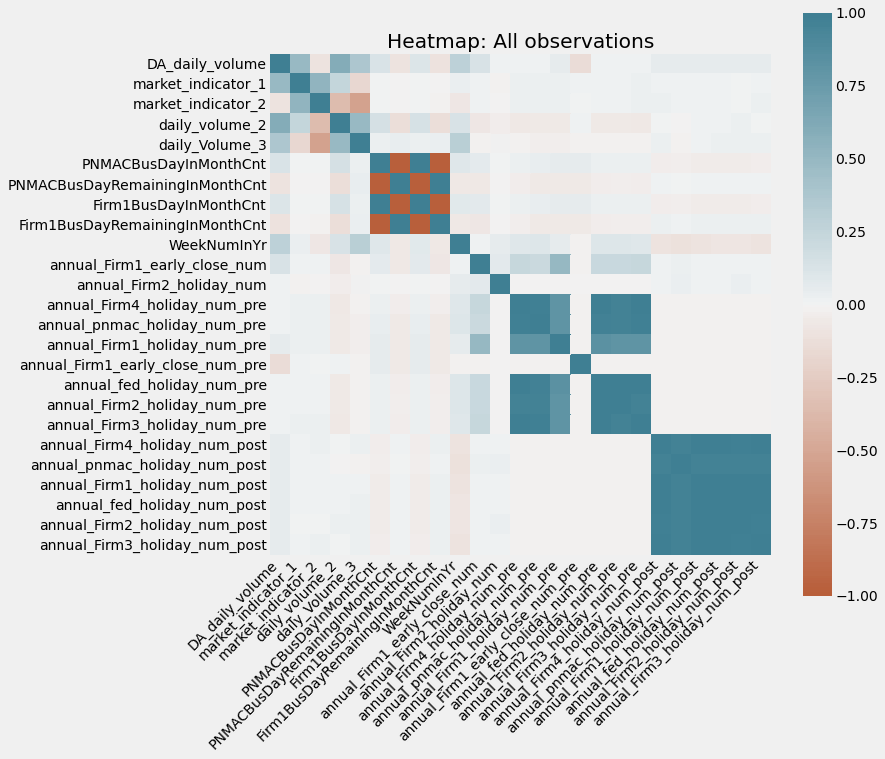

In [15]:
corr_df = df[["DA_daily_volume", "market_indicator_1",
"market_indicator_2",
"daily_volume_2",
"daily_Volume_3",
"WeekDayFlag",
"Firm1EarlyCloseFlag",
"Firm2HolidayFlag",
"PNMACBusDayInMonthCnt",
"PNMACBusDayRemainingInMonthCnt",
"Firm1BusDayInMonthCnt",
"Firm1BusDayRemainingInMonthCnt",
"WeekNumInYr",
"PNMACBusDayFlag",
"Firm1BusDayFlag",
"FederalBusDayFlag",
"Firm2BusDayFlag",
"Firm3BusDayFlag",
"Firm4BusDayFlag",
"annual_Firm1_early_close_num",
"annual_Firm2_holiday_num",
"annual_Firm4_holiday_num_pre",
"annual_pnmac_holiday_num_pre",
"annual_Firm1_holiday_num_pre",
"annual_Firm1_early_close_num_pre",
"annual_fed_holiday_num_pre",
"annual_Firm2_holiday_num_pre",
"annual_Firm3_holiday_num_pre",
"annual_Firm4_holiday_num_post",
"annual_pnmac_holiday_num_post",
"annual_Firm1_holiday_num_post",
"annual_fed_holiday_num_post",
"annual_Firm2_holiday_num_post",
"annual_Firm3_holiday_num_post"
]]

corr = corr_df.corr()

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(25, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
)
ax.set_title('Heatmap: All observations');

#### Correlation Heatmap: 2019 onward

Starting in 2019, the relationship between DA daily volume and market indicator 1 & 2 has changed. It shows a strong negative relationship. This tells me, it would be better off using more recent data to calibrate

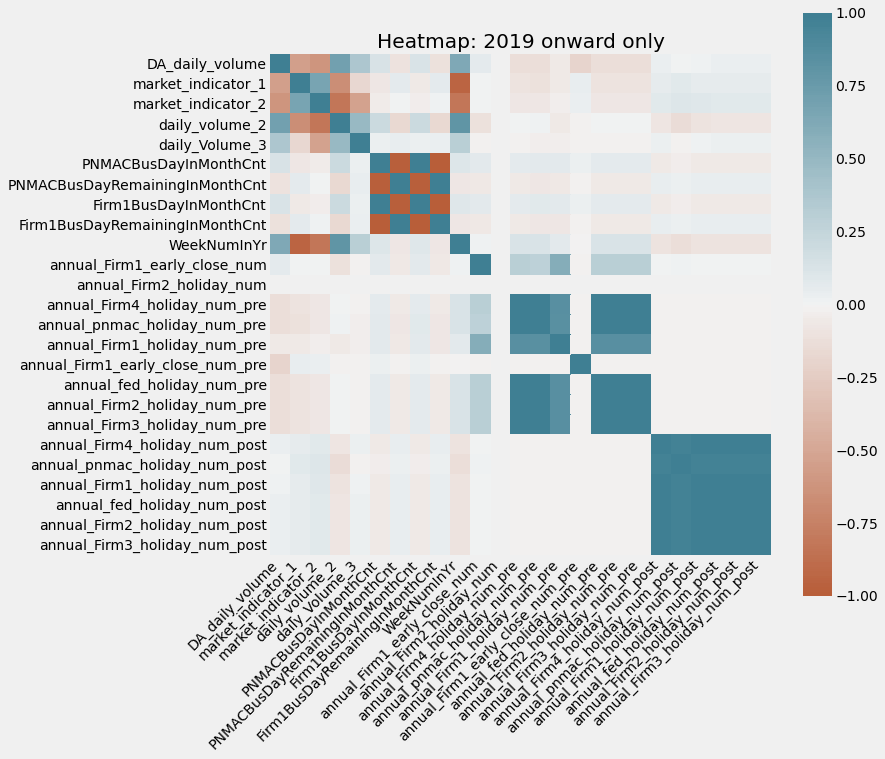

In [16]:
df_2019_on = df.loc[df.index>= '2019-01-01']
corr_df = df_2019_on[["DA_daily_volume",
"market_indicator_1",
"market_indicator_2",
"daily_volume_2",
"daily_Volume_3",
"WeekDayFlag",
"Firm1EarlyCloseFlag",
"Firm2HolidayFlag",
"PNMACBusDayInMonthCnt",
"PNMACBusDayRemainingInMonthCnt",
"Firm1BusDayInMonthCnt",
"Firm1BusDayRemainingInMonthCnt",
"WeekNumInYr",
"PNMACBusDayFlag",
"Firm1BusDayFlag",
"FederalBusDayFlag",
"Firm2BusDayFlag",
"Firm3BusDayFlag",
"Firm4BusDayFlag",
"annual_Firm1_early_close_num",
"annual_Firm2_holiday_num",
"annual_Firm4_holiday_num_pre",
"annual_pnmac_holiday_num_pre",
"annual_Firm1_holiday_num_pre",
"annual_Firm1_early_close_num_pre",
"annual_fed_holiday_num_pre",
"annual_Firm2_holiday_num_pre",
"annual_Firm3_holiday_num_pre",
"annual_Firm4_holiday_num_post",
"annual_pnmac_holiday_num_post",
"annual_Firm1_holiday_num_post",
"annual_fed_holiday_num_post",
"annual_Firm2_holiday_num_post",
"annual_Firm3_holiday_num_post"]]


corr = corr_df.corr()

plt.figure(figsize=(10, 10))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(25, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
)
ax.set_title('Heatmap: 2019 onward only');

#  Data Imputation

#### Fill Missing daily_volume_2

Missing daily_volume_2 is filled with 14 previous periods' rolling mean

In [17]:
#df['daily_volume_2']= df['daily_volume_2'].ffill()

In [18]:
df['daily_volume_2_fill'] = df['daily_volume_2'].fillna(df['daily_volume_2'].rolling(14,min_periods=1).mean())

In [19]:
#update daily volume 2 with imputed values
df['daily_volume_2'] = np.where( df['daily_volume_2'].isnull() == True, df['daily_volume_2_fill'], df['daily_volume_2'])

#### Imput missing "daily_Volume_3" based on Regression (market indicator 1, market indicator 2, and daily volume 2)

I am using this regression based method to imput daily volume 3 prior to 2019. Since this field is well populated starting in 2019, I presume we don't need to use this algorithm. 

In [20]:
df_missing = df[df['daily_Volume_3'].isnull()]
df_non_missing =df[df['daily_Volume_3'].notnull()]

X_train= df_non_missing[["market_indicator_1", "market_indicator_2", "daily_volume_2"]].values
y_train=df_non_missing["daily_Volume_3"].values

X_test= df_missing[["market_indicator_1", "market_indicator_2", "daily_volume_2"]].values
y_test=df_missing["daily_Volume_3"].values

In [21]:
X_train = add_constant(X_train)
X_test = add_constant(X_test)

x, y = np.array(X_train), np.array(y_train)
model = sm.OLS(y, x)
ols_model = model.fit()

In [22]:
#predict 
df_missing['daily_Volume_3_impute']= ols_model.predict(X_test)

#append to non missing data
df = df_non_missing.append(df_missing)

#update daily volume 3 with imputed values
df['daily_Volume_3'] = np.where( df['daily_Volume_3'].isnull() == True, df['daily_Volume_3_impute'], df['daily_Volume_3'])

# EDA

#### Market Indicator 

At first glance, I suspect that market indicator 1 closely follows the effective fed funds rate and market indicator 2 simillarily follows the 30-year mortgage rate. The spread between two rates (in yellow) are calculated.

This observation led me to try ARIMA, predicting 1-day ahead market rates to use as features. However, these features didn't show much predictive power; hence these are dropped in the final feature selection process.

Text(0.5, 1.0, 'Market Indicator Trends')

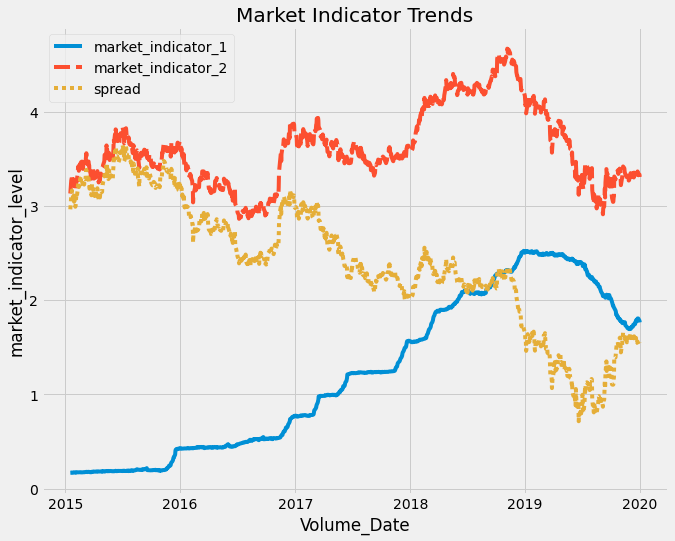

In [23]:
df['spread'] = df['market_indicator_2'] - df['market_indicator_1']
columns = ['market_indicator_1', 'market_indicator_2', 'spread']

fig, ax = plt.subplots(figsize=(10, 8))
ax =sns.lineplot(data = df[columns])
ax.set_ylabel('market_indicator_level')
ax.set_title('Market Indicator Trends')

From the graph below, we can infer that daily volume started to increase sharply in 2019 as market indicators started to drop.

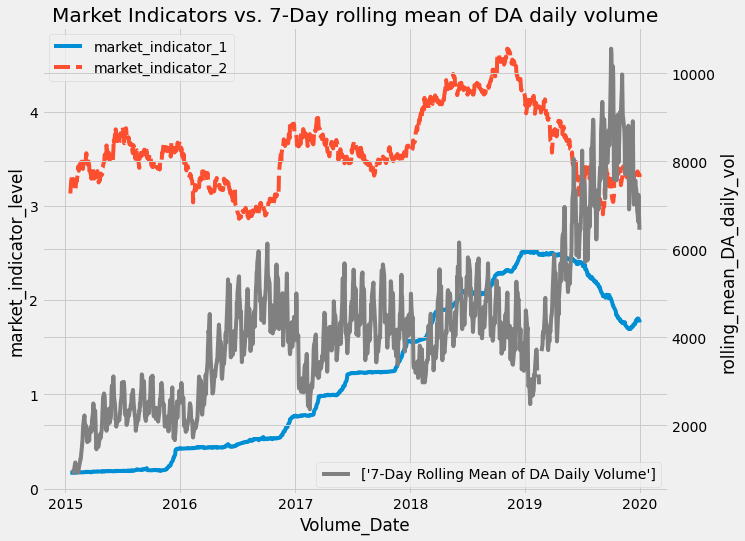

In [24]:
plot_df =  df[['market_indicator_1', 'market_indicator_2', 'DA_daily_volume']]
plot_df['rolling_mean_DA_daily_vol'] = plot_df['DA_daily_volume'].rolling(7).mean()

fig, ax = plt.subplots(figsize=(10, 8))

new_labels = ['7-Day Rolling Mean of DA Daily Volume']
ax1= sns.lineplot(data = plot_df[['market_indicator_1', 'market_indicator_2']])
ax1.set_ylabel('market_indicator_level')
ax2 = ax1.twinx()
sns.lineplot(data=plot_df['rolling_mean_DA_daily_vol'], color="gray", ax=ax2, label = new_labels)
ax1.set_title('Market Indicators vs. 7-Day rolling mean of DA daily volume')
ax2.legend(loc='lower right')

Text(0.5, 1.0, 'Scatterplot: 1-Day Ahead Daily Volume vs. Market_Indicator_1')

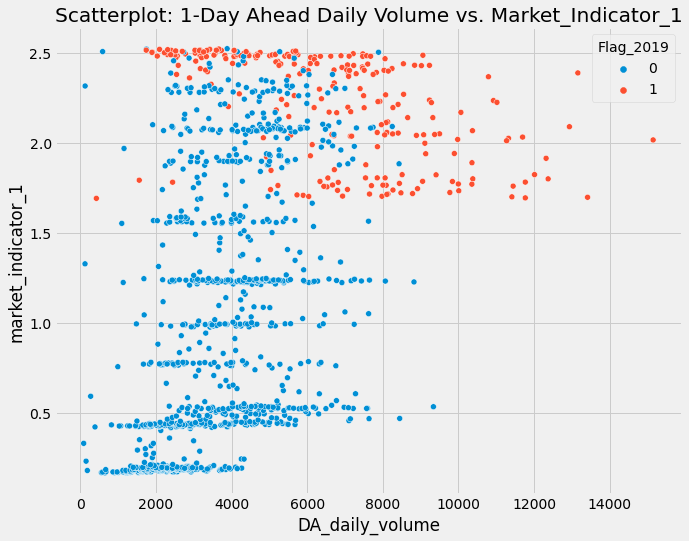

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df, x='DA_daily_volume', y='market_indicator_1', hue='Flag_2019')
plt.title('Scatterplot: 1-Day Ahead Daily Volume vs. Market_Indicator_1')

Text(0.5, 1.0, 'Scatterplot: 1-Day Ahead Daily Volume vs. Market_Indicator_2')

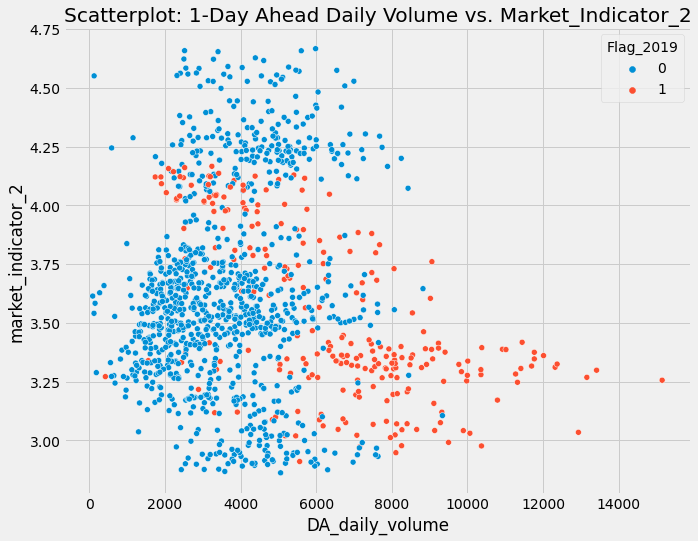

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df, x='DA_daily_volume', y='market_indicator_2', hue='Flag_2019')
plt.title('Scatterplot: 1-Day Ahead Daily Volume vs. Market_Indicator_2')

#### Daily Volume

Daily volume, Daily volume 2, and Daily volume 3 (imputed prior to 2019) all show strong positive correlations.

Text(0.5, 1.0, 'Scatterplot: 1-Day Ahead Daily Volume vs. Daily Volume')

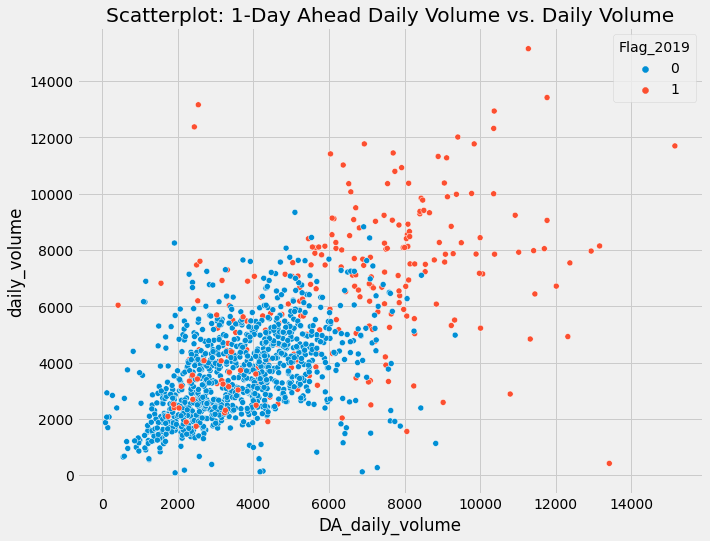

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df, x='DA_daily_volume', y='daily_volume', hue='Flag_2019')
plt.title('Scatterplot: 1-Day Ahead Daily Volume vs. Daily Volume')

Text(0.5, 1.0, 'Scatterplot: 1-Day Ahead Daily Volume vs. Daily Volume 2')

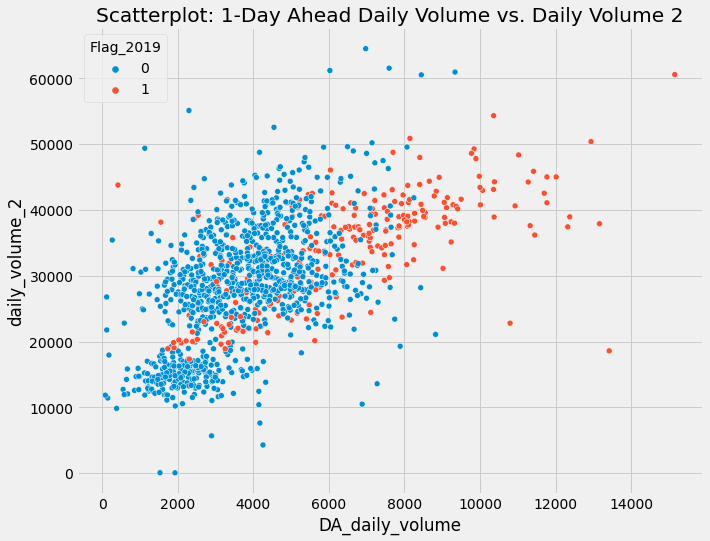

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df, x='DA_daily_volume', y='daily_volume_2', hue='Flag_2019')
plt.title('Scatterplot: 1-Day Ahead Daily Volume vs. Daily Volume 2')

Daily Volume 3 is missing prior to 2019; however, after imputing prior to 2019 data points based on regression, it can be seen that daily volume 3 shows a positive correlation w.r.t. one-day ahead daily volume.

Text(0.5, 1.0, 'Scatterplot: 1-Day Ahead Daily Volume vs. Daily Volume 3')

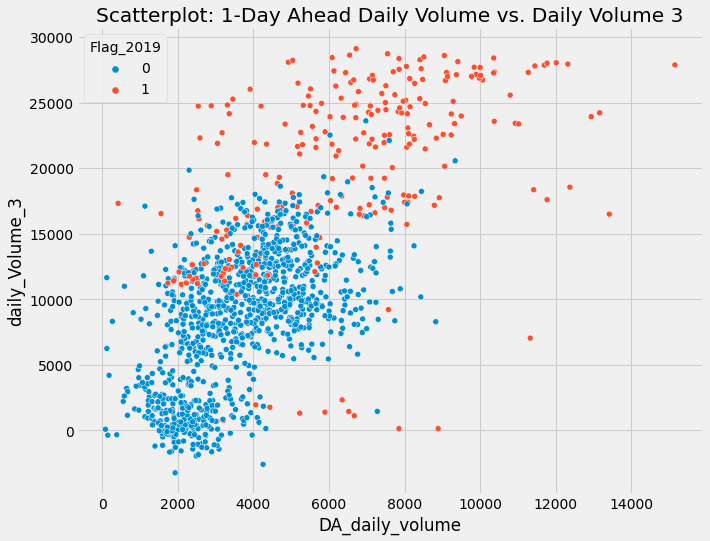

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=df, x='DA_daily_volume', y='daily_Volume_3', hue='Flag_2019')
plt.title('Scatterplot: 1-Day Ahead Daily Volume vs. Daily Volume 3')

#### BusDayFlag

Many of business day flags are close to singular and a couple of N flags are in the beginning of time series. These are all dropped and I'm keeping below 2 variables in the modeling features.

    "Firm1BusDayInMonthCnt_DA_1"
    "Firm1BusDayRemainingInMonthCnt_DA_1"

In [30]:
df.groupby(['FederalBusDayFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,FederalBusDayFlag,count,mean
0,N,2,1731.00
1,Y,1238,4204.05


In [31]:
df.groupby(['Firm1BusDayFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm1BusDayFlag,count,mean
0,N,2,1731.00
1,Y,1238,4204.05


In [32]:
df.groupby(['Firm2BusDayFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm2BusDayFlag,count,mean
0,N,4,3532.50
1,Y,1236,4202.22


In [33]:
df.groupby(['Firm3BusDayFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm3BusDayFlag,count,mean
0,N,2,1731.00
1,Y,1238,4204.05


In [34]:
df.groupby(['Firm4BusDayFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm4BusDayFlag,count,mean
0,N,2,1731.00
1,Y,1238,4204.05


In [35]:
df.groupby(['PNMACBusDayFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,PNMACBusDayFlag,count,mean
0,N,2,1731.00
1,Y,1238,4204.05


In [36]:
df.groupby(['Firm1BusDayInMonthCnt'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm1BusDayInMonthCnt,count,mean
0,1,59,5292.39
1,2,59,4449.64
2,3,58,3968.43
3,4,59,3811.75
4,5,59,3977.49
5,6,59,3818.29
6,7,59,3460.51
7,8,59,3366.78
8,9,60,3752.40
9,10,59,4032.02


In [37]:
df.groupby(['Firm1BusDayRemainingInMonthCnt'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm1BusDayRemainingInMonthCnt,count,mean
0,1,59,5909.68
1,2,60,5123.25
2,3,60,4892.52
3,4,60,4553.22
4,5,60,4252.55
5,6,60,3528.57
6,7,60,3770.80
7,8,60,4100.90
8,9,61,4051.28
9,10,59,4074.22


In [38]:
df.groupby(['PNMACBusDayInMonthCnt'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,PNMACBusDayInMonthCnt,count,mean
0,1,59,5292.39
1,2,59,4449.64
2,3,58,3968.43
3,4,59,3811.75
4,5,59,3977.49
5,6,56,3774.86
6,7,58,3407.62
7,8,56,3490.11
8,9,59,3678.08
9,10,57,3803.88


In [39]:
df.groupby(['PNMACBusDayRemainingInMonthCnt'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,PNMACBusDayRemainingInMonthCnt,count,mean
0,1,58,5866.24
1,2,60,5223.92
2,3,60,4818.18
3,4,60,4584.92
4,5,59,4256.53
5,6,60,3626.97
6,7,60,3659.70
7,8,59,4105.78
8,9,61,4111.89
9,10,59,4027.29


#### Early Close Flags

The early close flags, esepcially "annual_Firm1_early_close_num_pre", show that DA volume drops significantly when the close_num is non zero. We will use these features.

In [40]:
df.groupby(['Firm1EarlyCloseFlag'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,Firm1EarlyCloseFlag,count,mean
0,N,1212,4153.97
1,Y,28,6194.86


In [41]:
df.groupby(['annual_Firm1_early_close_num'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm1_early_close_num,count,mean
0,0,1212,4153.97
1,1,4,6430.25
2,2,5,4661.80
3,3,5,7201.00
4,4,5,5930.80
5,5,5,6226.20
6,6,4,6909.00


In [42]:
df.groupby(['annual_Firm1_early_close_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm1_early_close_num_pre,count,mean
0,0,1219,4245.35
1,1,4,1814.50
2,2,4,1006.00
3,4,4,1855.50
4,5,5,1420.60
5,6,4,1796.75


#### Months, Weekdays, Holidays

DA daily volume is the highest in October and on Monday. DA daily volume drops quite significantly during the winter season.



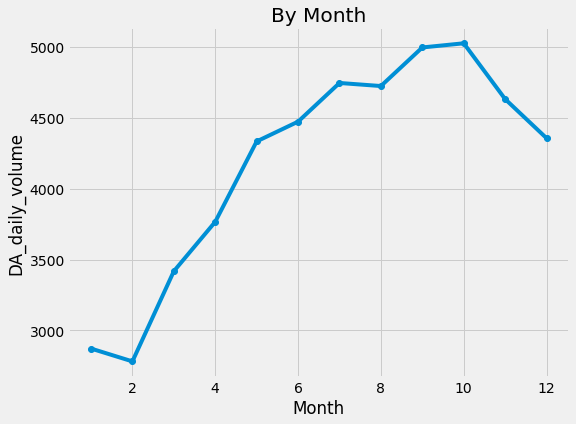

In [43]:
test =df.groupby(['Month'])['DA_daily_volume'].mean().plot(marker='o', figsize=(8,6))
plt.ylabel('DA_daily_volume')
plt.title("By Month")
plt.show()

WeekDay effect is quite significant, we can see that DA volume drops significantly when it's Friday(4) or Saturday(5).

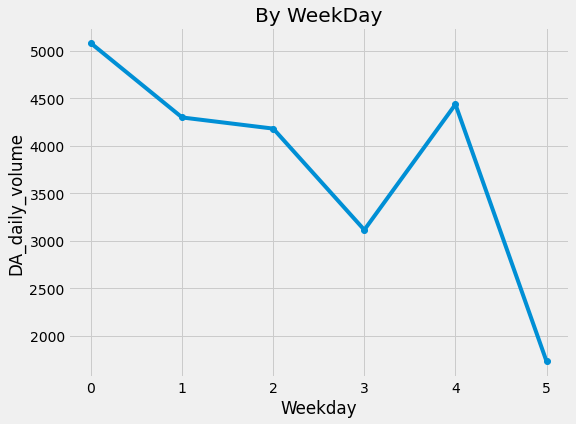

In [44]:
#dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday',  6:'Sunday'}
#df['Weekday'] = df['Weekday'].map(dayOfWeek)

test =df.groupby(['Weekday'])['DA_daily_volume'].mean().plot(marker='o', figsize=(8,6))
plt.ylabel('DA_daily_volume')
plt.title("By WeekDay")
plt.show()

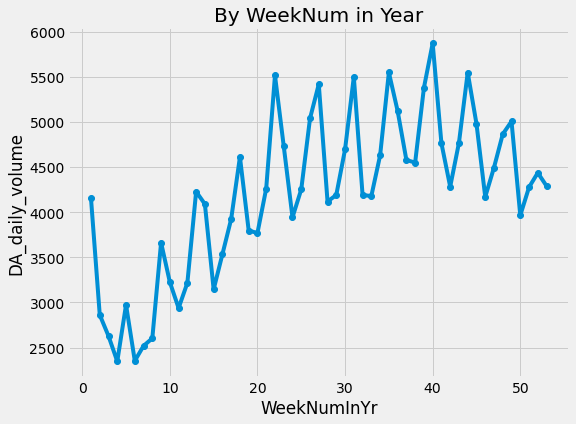

In [45]:
test =df.groupby(['WeekNumInYr'])['DA_daily_volume'].mean().plot(marker='o', figsize=(8,6))
plt.ylabel('DA_daily_volume')
plt.title("By WeekNum in Year")
plt.show()

In [46]:
df.groupby(['annual_pnmac_holiday_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_pnmac_holiday_num_pre,count,mean
0,0,1226,4207.31
1,1,3,5035.33
2,2,5,217.00
3,4,4,5484.75
4,8,2,5891.50


In [47]:
df.groupby(['annual_fed_holiday_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_fed_holiday_num_pre,count,mean
0,0,1224,4207.86
1,1,3,5035.33
2,2,5,217.00
3,3,2,3870.00
4,5,1,8824.00
5,6,3,4371.67
6,10,2,5891.50


In [48]:
df.groupby(['annual_Firm2_holiday_num'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm2_holiday_num,count,mean
0,0,1238,4198.22
1,2,1,7277.00
2,3,1,3391.00


In [49]:
df.groupby(['annual_Firm1_holiday_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm1_holiday_num_pre,count,mean
0,0,1220,4199.00
1,1,3,5035.33
2,2,5,217.00
3,3,2,3870.00
4,5,1,8824.00
5,6,3,4371.67
6,7,1,6422.00
7,8,3,7071.33
8,11,2,5891.50


In [50]:
df.groupby(['annual_Firm2_holiday_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm2_holiday_num_pre,count,mean
0,0,1223,4209.92
1,1,3,5035.33
2,2,4,203.75
3,3,3,1637.33
4,4,1,4777.00
5,6,4,5484.75
6,10,1,7886.00
7,11,1,3897.00


In [51]:
df.groupby(['annual_Firm3_holiday_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm3_holiday_num_pre,count,mean
0,0,1225,4208.32
1,1,3,5035.33
2,2,5,217.00
3,3,1,2963.00
4,5,1,8824.00
5,6,3,4371.67
6,8,1,3897.00
7,10,1,7886.00


In [52]:
df.groupby(['annual_Firm4_holiday_num_pre'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm4_holiday_num_pre,count,mean
0,0,1225,4208.32
1,1,3,5035.33
2,2,5,217.00
3,3,1,2963.00
4,5,1,8824.00
5,6,3,4371.67
6,8,1,3897.00
7,10,1,7886.00


In [53]:
df.groupby(['annual_Firm1_holiday_num_post'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm1_holiday_num_post,count,mean
0,0,1196,4157.22
1,1,4,6140.50
2,2,5,7201.00
3,3,4,4711.25
4,4,5,5439.20
5,5,5,6109.20
6,6,4,7141.75
7,7,4,6464.75
8,8,2,2573.00
9,9,5,2682.00


In [54]:
df.groupby(['annual_Firm2_holiday_num_post'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm2_holiday_num_post,count,mean
0,0,1196,4157.22
1,1,4,6140.50
2,2,4,7182.00
3,3,4,5253.00
4,4,4,5770.75
5,5,5,5559.80
6,6,4,6931.75
7,7,5,6044.60
8,8,5,4223.20
9,9,5,2572.60


In [55]:
df.groupby(['annual_Firm3_holiday_num_post'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm3_holiday_num_post,count,mean
0,0,1197,4157.23
1,1,4,6140.50
2,2,5,7201.00
3,3,5,4779.60
4,4,5,5643.20
5,5,5,6787.80
6,6,4,6392.00
7,7,5,4610.20
8,8,4,2908.75
9,9,4,3500.00


In [56]:
df.groupby(['annual_Firm4_holiday_num_post'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_Firm4_holiday_num_post,count,mean
0,0,1197,4157.23
1,1,4,6140.50
2,2,5,7201.00
3,3,5,4779.60
4,4,5,5643.20
5,5,5,6787.80
6,6,4,6392.00
7,7,5,4610.20
8,8,4,2908.75
9,9,4,3500.00


In [57]:
df.groupby(['annual_fed_holiday_num_post'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_fed_holiday_num_post,count,mean
0,0,1196,4157.22
1,1,4,6140.50
2,2,5,7201.00
3,3,4,4711.25
4,4,5,5439.20
5,5,5,6109.20
6,6,4,7141.75
7,7,5,5879.40
8,8,5,2764.40
9,9,5,3220.00


In [58]:
df.groupby(['annual_pnmac_holiday_num_post'])['DA_daily_volume'].agg(["count", "mean"]).round(2).reset_index()

,annual_pnmac_holiday_num_post,count,mean
0,0,1204,4163.64
1,1,4,6140.50
2,2,5,7201.00
3,3,5,5737.20
4,4,4,6965.00
5,5,5,6696.60
6,6,5,2971.40
7,7,5,2555.20
8,8,3,5606.67


# Feature Generation

#### Take 1st order differencing on market indicators and daily volumes

In [59]:
df['market_indicator_1_diff'] = df['market_indicator_1'].diff(1)
df['market_indicator_2_diff'] = df['market_indicator_2'].diff(1)
df['daily_volume_diff'] = df['daily_volume'].diff(1)
df['daily_volume_2_diff'] = df['daily_volume_2'].diff(1)
df['daily_Volume_3_diff'] = df['daily_Volume_3'].diff(1)

#### Create lag variables: up to t-7

In [60]:
def fn_lagged(col):
    num_lags = [1,2,3,4,5,6,7]
    for lag in num_lags:
        df[col+'_lag_' + str(lag)] = df[col].shift(lag)

In [61]:
fn_lagged('market_indicator_1')
fn_lagged('market_indicator_2')
fn_lagged('daily_volume')
fn_lagged('daily_volume_2')
fn_lagged('daily_Volume_3')
fn_lagged('market_indicator_1_diff')
fn_lagged('market_indicator_2_diff')
fn_lagged('daily_volume_diff')
fn_lagged('daily_volume_2_diff')
fn_lagged('daily_Volume_3_diff')

#### Combine Some of Holiday related variables 

Many of holiday related variabels are redundant. To reduce dimensionality, some of those and creating avg_holiday_num_pre and avg_holiday_num_post

In [62]:
df['avg_holiday_num_pre'] = (df['annual_Firm1_holiday_num_pre'] + 
df['annual_Firm2_holiday_num_pre'] +
df['annual_Firm3_holiday_num_pre'] +
df['annual_Firm4_holiday_num_pre'] + 
df['annual_fed_holiday_num_pre'] + 
df['annual_pnmac_holiday_num_pre'])/6

In [63]:
df['avg_holiday_num_post'] = (df['annual_Firm1_holiday_num_post'] + 
df['annual_Firm2_holiday_num_post'] +
df['annual_Firm3_holiday_num_post'] +
df['annual_Firm4_holiday_num_post'] + 
df['annual_fed_holiday_num_post'] + 
df['annual_pnmac_holiday_num_post'])/6

#### Create 1-day ahead flags for weekday, holidays, early close, etc. 

These tomorrow variables are known in advance, as of today 

In [64]:
cols = ["WeekDayFlag",
"Month",
"Weekday",
"Firm2HolidayFlag",
'Firm1BusDayInMonthCnt',
'Firm1BusDayRemainingInMonthCnt',
"Firm1EarlyCloseFlag",
"annual_Firm1_early_close_num",
"annual_Firm1_early_close_num_pre",
"annual_Firm2_holiday_num"]

for col in cols:
        df[col+'_DA_' + str(1)] = df[col].shift(-1)

# Model Development

#### Choose calibration period 

In [65]:
df = df.sort_index()
#df_model = df
df_model = df.loc[df.index>= "2018-01-01"]

#### Select Features

Note: daily_volume_2 related features are limited to max t-2 lags as this feature may not be available up to 10 days at the time of model fitting. 

In [66]:
ml_dataset = df_model[["DA_daily_volume",
"market_indicator_1",
"market_indicator_2",
"daily_volume",
"daily_volume_2",
"daily_Volume_3",           
"WeekDayFlag",
"Month",
"Weekday",
"Firm2HolidayFlag",
'Firm1BusDayInMonthCnt',
'Firm1BusDayRemainingInMonthCnt',
"Firm1EarlyCloseFlag",
"annual_Firm1_early_close_num",
"annual_Firm1_early_close_num_pre",
"annual_Firm2_holiday_num",
"WeekDayFlag_DA_1",
"Month_DA_1",
"Weekday_DA_1",
"Firm2HolidayFlag_DA_1",
"Firm1BusDayInMonthCnt_DA_1",
"Firm1BusDayRemainingInMonthCnt_DA_1",
"Firm1EarlyCloseFlag_DA_1",
"annual_Firm1_early_close_num_DA_1",
"annual_Firm2_holiday_num_DA_1",    
"annual_Firm1_early_close_num_pre_DA_1", 
"avg_holiday_num_pre",
"avg_holiday_num_post",
"market_indicator_1_lag_1",
"market_indicator_1_lag_2",
"market_indicator_1_lag_3",
"market_indicator_1_lag_4",
"market_indicator_1_lag_5",
"market_indicator_1_lag_6",
"market_indicator_1_lag_7",
"market_indicator_2_lag_1",
"market_indicator_2_lag_2",
"market_indicator_2_lag_3",
"market_indicator_2_lag_4",
"market_indicator_2_lag_5",
"market_indicator_2_lag_6",
"market_indicator_2_lag_7",
"daily_volume_lag_1",
"daily_volume_lag_2",
"daily_volume_lag_3",
"daily_volume_lag_4",
"daily_volume_lag_5",
"daily_volume_lag_6",
"daily_volume_lag_7", 
"daily_volume_2_lag_1",
"daily_volume_2_lag_2",
#"daily_volume_2_lag_3",
#"daily_volume_2_lag_4",
#"daily_volume_2_lag_5",
#"daily_volume_2_lag_6",
#"daily_volume_2_lag_7", 
"daily_Volume_3_lag_1",
"daily_Volume_3_lag_2",
"daily_Volume_3_lag_3",
"daily_Volume_3_lag_4",
"daily_Volume_3_lag_5",
"daily_Volume_3_lag_6",
"daily_Volume_3_lag_7",
"market_indicator_1_diff",
"market_indicator_2_diff",
"daily_volume_2_diff",
"daily_Volume_3_diff",                      
"market_indicator_1_diff_lag_1",
"market_indicator_1_diff_lag_2",
"market_indicator_1_diff_lag_3",
"market_indicator_1_diff_lag_4",
"market_indicator_1_diff_lag_5",
"market_indicator_1_diff_lag_6",
"market_indicator_1_diff_lag_7",
"market_indicator_2_diff_lag_1",
"market_indicator_2_diff_lag_2",
"market_indicator_2_diff_lag_3",
"market_indicator_2_diff_lag_4",
"market_indicator_2_diff_lag_5",
"market_indicator_2_diff_lag_6",
"market_indicator_2_diff_lag_7",
"daily_volume_diff_lag_1",
"daily_volume_diff_lag_2",
"daily_volume_diff_lag_3",
"daily_volume_diff_lag_4",
"daily_volume_diff_lag_5",
"daily_volume_diff_lag_6",
"daily_volume_diff_lag_7",
"daily_volume_2_diff_lag_1",
"daily_volume_2_diff_lag_2",
#"daily_volume_2_diff_lag_3",
#"daily_volume_2_diff_lag_4",
#"daily_volume_2_diff_lag_5",
#"daily_volume_2_diff_lag_6",
#"daily_volume_2_diff_lag_7",                       
"daily_Volume_3_diff_lag_1",
"daily_Volume_3_diff_lag_2",
"daily_Volume_3_diff_lag_3",
"daily_Volume_3_diff_lag_4",
"daily_Volume_3_diff_lag_5",
"daily_Volume_3_diff_lag_6",
"daily_Volume_3_diff_lag_7" ,   
]]

#### Drop missing due to lagged

In [67]:
ml_dataset=ml_dataset.dropna()
ml_dataset.shape

(489, 92)

#### Pre-processing: Categorical Features

In [68]:
cat_features = ["WeekDayFlag",
"Month",
"Weekday",
"Firm2HolidayFlag",
'Firm1BusDayInMonthCnt',
'Firm1BusDayRemainingInMonthCnt',
"Firm1EarlyCloseFlag",
"annual_Firm1_early_close_num",
"annual_Firm1_early_close_num_pre",
"annual_Firm2_holiday_num",
"WeekDayFlag_DA_1",
"Month_DA_1",
"Weekday_DA_1",
"Firm2HolidayFlag_DA_1",
"Firm1BusDayInMonthCnt_DA_1",
"Firm1BusDayRemainingInMonthCnt_DA_1",
"Firm1EarlyCloseFlag_DA_1",
"annual_Firm1_early_close_num_DA_1",
"annual_Firm2_holiday_num_DA_1",    
"annual_Firm1_early_close_num_pre_DA_1"] 

for f in ml_dataset[cat_features]:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(ml_dataset[f].values))
    ml_dataset[f] = lbl.transform(list(ml_dataset[f].values))

#### Pre-processing: Numerical Features

In [69]:
num_features = [x for x in ml_dataset.columns if x not in [cat_features, 'DA_daily_volume']]

for f in ml_dataset[num_features] :
    if ml_dataset[f].dtype=='float':
        _min = ml_dataset[f].min()
        _max = ml_dataset[f].max()
        scale = _max - _min
        shift = _min

        ml_dataset[f] = (ml_dataset[f] - shift).astype(np.float64) / scale

#### Create a Target variable

In [70]:
ml_dataset['__target__'] = ml_dataset['DA_daily_volume']
del ml_dataset['DA_daily_volume']


# Remove rows for which the target is unknown.
ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

#### Splitting into Train/Test Data

In [71]:
train, test = train_test_split(ml_dataset, test_size=0.2, random_state=101)
print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 391 rows and 92 columns
Test data has 98 rows and 92 columns


In [72]:
train_X = train.drop('__target__', axis=1)
test_X = test.drop('__target__', axis=1)

train_Y = np.array(train['__target__'])
test_Y = np.array(test['__target__'])

### Define Regressor: Gradient Boosting Machine

In [73]:
gbm_regress = GradientBoostingRegressor(random_state=101)
gbm_parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(100, 1000),
              'max_depth'    : sp_randInt(3, 10),
              'max_features' : sp_randInt(5, 30)
                 }

### Randomized Grid Search Function

Define a grid search function.  The randomized grid search function searchs for the best tuned hyperparameters when scored by "neg_mean_squared_error".

In [74]:
def fn_rand_gridsearch(model, params, n_iter, k):
    
    kfold = ShuffleSplit(n_splits=k)
    randm_src = RandomizedSearchCV(estimator=model, param_distributions = params, 
                                   scoring="neg_mean_squared_error", cv = kfold, n_iter = n_iter,
                                   n_jobs=-1, random_state = 101)

    
    randm_result= randm_src.fit(train_X, train_Y)
    
    lr = randm_src.best_params_['learning_rate']
    depth = randm_src.best_params_['max_depth']
    num_feature = randm_src.best_params_['max_features']
    n = randm_src.best_params_['n_estimators']
    sub = randm_src.best_params_['subsample']
    

    print(" Results from Random Search " )
    print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
    print("\n The best score across ALL searched params:\n", randm_src.best_score_)
    print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)
    return [lr, depth, num_feature, n, sub]

In [75]:
# perform grid search for GBM regressor
lr, depth, num_feature, n, sub = fn_rand_gridsearch(gbm_regress, gbm_parameters, 10, 10)

 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.048484537426400576, max_depth=4,
                          max_features=20, n_estimators=364, random_state=101,
                          subsample=0.994317901154097)

 The best score across ALL searched params:
 -1915560.5993210557

 The best parameters across ALL searched params:
 {'learning_rate': 0.048484537426400576, 'max_depth': 4, 'max_features': 20, 'n_estimators': 364, 'subsample': 0.994317901154097}


Pass the tuned hyperparameters to GBM regressor and train the model with trainig data set

In [76]:
# Fit GBM model with the chosen hyperparameters
gbm_regress = GradientBoostingRegressor(
                     learning_rate = lr,
                      max_depth = depth,
                      max_features = num_feature,
                      n_estimators = n,
                      subsample = sub,
                      loss = 'ls',
                      random_state = 101,
                      verbose = 0
                     )
%time gbm_regress.fit(train_X, train_Y)

Wall time: 1.75 s


GradientBoostingRegressor(learning_rate=0.048484537426400576, max_depth=4,
                          max_features=20, n_estimators=364, random_state=101,
                          subsample=0.994317901154097)

### Function to plot Importance of features

The importance of feature plot shows that market_indicator_2_lag_2 (2 days ago's market indicator 2) and Weekday_DA_1 (tomorrow's weekday) are two most important variables. We will examine the partial dependence plots related to these variables later. 

In [77]:
def fn_importance_features(model):
    clf = model
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, clf.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

    # Plot the results
    pd.DataFrame(feature_importances_data)\
        .set_index('feature')\
        .sort_values(by='importance')[-10::]\
        .plot(title='Top 10 most important features: '+ str(type(model).__name__),
              kind='barh',figsize=(10, 6),
              color='#348ABD',alpha=0.6,
              lw='1', edgecolor='#348ABD',grid=False,)

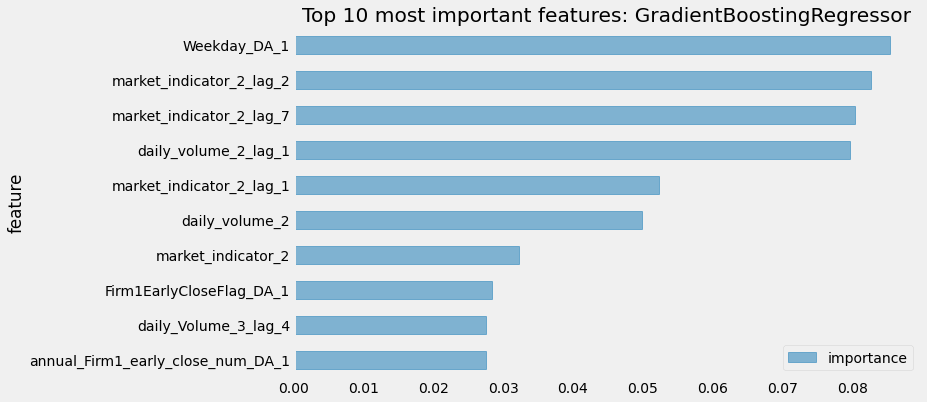

In [78]:
fn_importance_features(gbm_regress)

### Predict Test Data Set

GBM achieved R-sq of 82% on test data. In addition to these performance metrics,  two plots are generated: prediction using all test data set and prediction using 2019 onward only.

Looking at these prediction plots, the model is generally able to capture peaks/valleys as well as an upward trend shown in 2019. The errors are relatively normally distributed as well.

In [79]:
def fn_predict (model):
    pred = model.predict(test_X)
    predictions = pd.Series(data=pred, index=test_X.index, name='predicted_value')

    # Build scored dataset
    results_test = test_X.join(predictions, how='left')
    results_test = results_test.join(test['__target__'], how='left')
    results_test = results_test.rename(columns= {'__target__': 'DA_daily_volume'})
    
    MAE = metrics.mean_absolute_error(results_test['DA_daily_volume'], results_test['predicted_value'])
    MSE = metrics.mean_squared_error(results_test['DA_daily_volume'], results_test['predicted_value'])
    rmse = np.sqrt(MSE)
    r2 = metrics.r2_score(results_test['DA_daily_volume'], results_test['predicted_value'])
    
    print("MAE:",MAE)
    print("MSE:", MSE)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    
    #Prediction plot
    cols = ['predicted_value', 'DA_daily_volume']
    pred = results_test[cols]
    pred.plot(marker='o',figsize=(10,6))
    plt.ylabel('DA Daily Volume')
    plt.title('DA Daily Volume Predicted vs. Actual:' +str(type(model).__name__))
    plt.show
    
    # Predict 2019 only
    results_2019 = results_test.loc[results_test.index>= '2019-01-01']
    pred_2019 = results_2019[cols]
    pred_2019.plot(marker='o',figsize=(10,6))
    plt.ylabel('DA Daily Volume')
    plt.title('2019 Prediction: ' +str(type(model).__name__))
    plt.show
    
    #scatter plot
    fig, ax = plt.subplots(figsize=(10,6))
    sns.scatterplot(data=pred, x='DA_daily_volume', y='predicted_value')
    plt.title('Scatterplot:' +str(type(model).__name__))
    plt.show

    
    #error distribution
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(pred['DA_daily_volume'] - pred['predicted_value'])
    plt.title('Error Distribution:' +str(type(model).__name__))
    plt.show

MAE: 828.4600697062982
MSE: 1274418.3129902452
RMSE: 1128.9013743415521
R-Squared: 0.8034530232933281


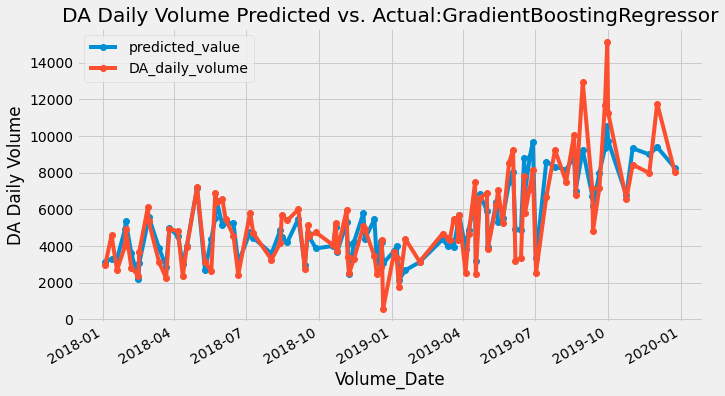

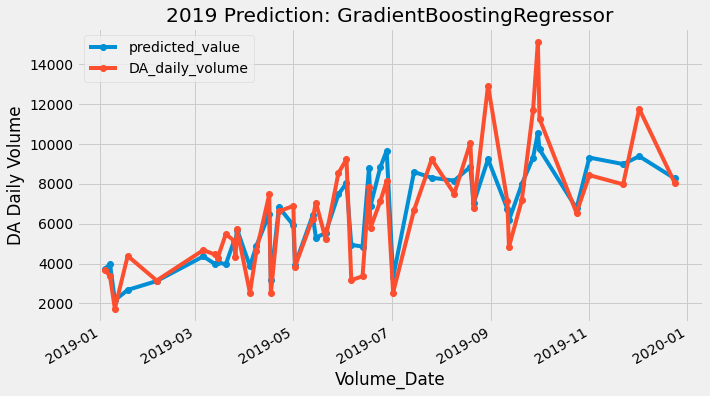

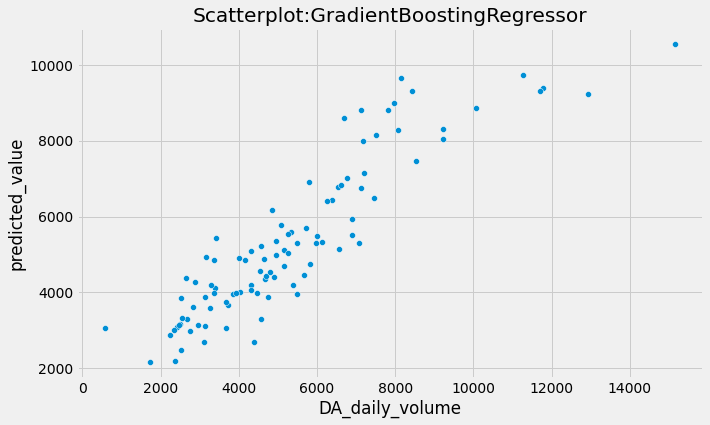

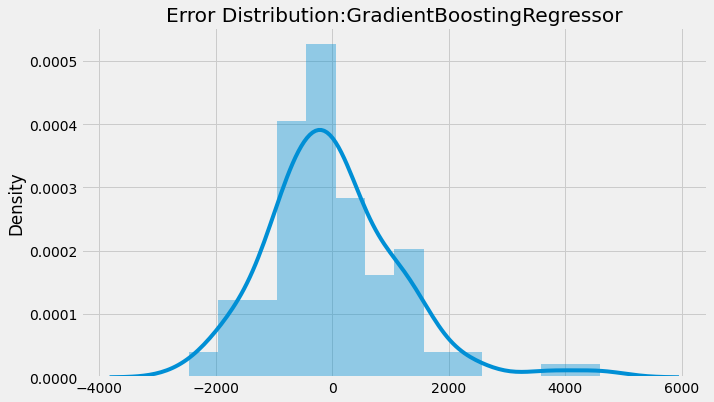

In [80]:
# GBM regressor: predict 1-day ahead usig test set
fn_predict(gbm_regress)

### Partial Dependence Plots

Partial dependence plots of top 2 most important variables are plotted. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value. A blue shaded area indicates level of confidence. 

The most important feature is found to be Weekday_DA_1, tomorrow's day of the week.  This Weekday is extracted from Volume_Day. Based on the map below, we can infer that the predicted DA daily volume drops significantly on the weekend. 

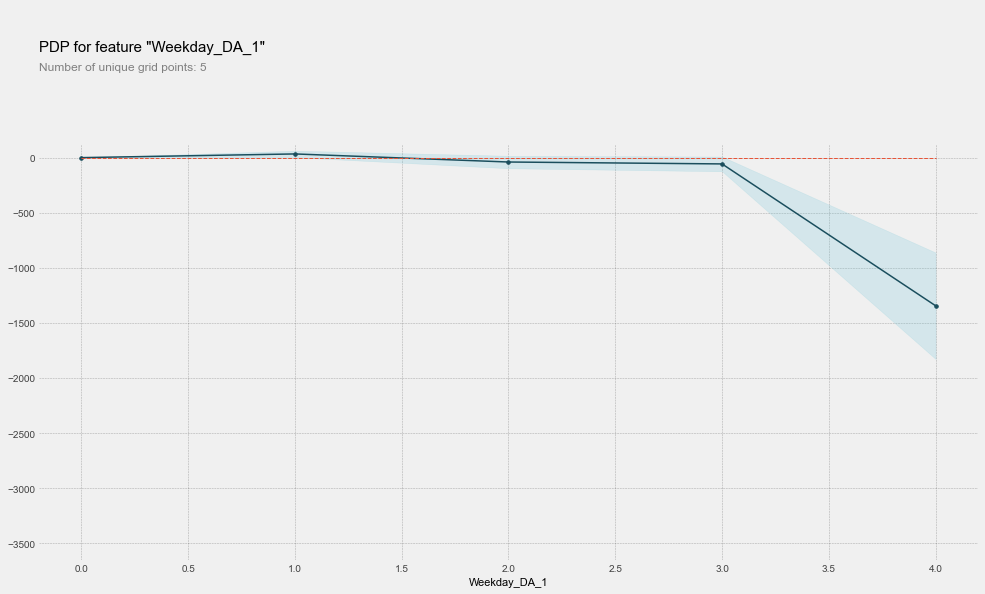

In [81]:
pdp_dist = pdp.pdp_isolate(model=gbm_regress, dataset=train_X
                           , model_features=train_X.columns
                           , feature='Weekday_DA_1')
pdp.pdp_plot(pdp_dist, 'Weekday_DA_1');

Not surprisingly, market indicator 2 related variables are found to be important. This feature shows a non-linear trend as well as strong negative relationship w.r.t DA daily volume.  It is interesting to note that the predicted DA daily volume is indifferent when market_indicator_2_lag_2 increase is in between 0.4 to 0.8. However, the prediction drops significantly when this feature incrases more than 0.8. 

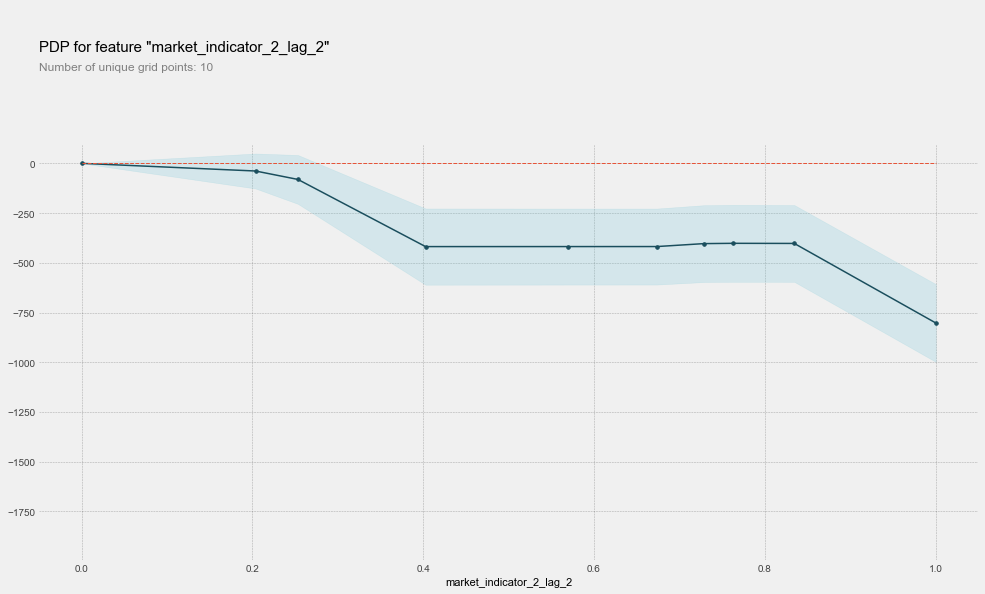

In [82]:
pdp_dist = pdp.pdp_isolate(model=gbm_regress, dataset=train_X
                           , model_features=train_X.columns
                           , feature='market_indicator_2_lag_2')
pdp.pdp_plot(pdp_dist, 'market_indicator_2_lag_2');

### Generate an output file

Generating an output file using all data

In [83]:
# full dataset
df_X = train_X.append(test_X)

#predict
%time _predictions = gbm_regress.predict(df_X)
predictions = pd.Series(data=_predictions, index=df_X.index, name='DayAhead_Prediction')

# Build scored dataset
results = df_X.join(predictions, how='left')
results = results.sort_index()
results = pd.DataFrame(results['DayAhead_Prediction'])
#results.head()

Wall time: 21 ms


In [84]:
results.to_csv("predictions_test.csv", index=True, header=True)

### User to supply new data